# Parameter estimation in material homogenization

This notebook illustrates performing parameter estimation tasks in UQpy for a finite element model. The problem is adapted from http://sfepy.org/doc-devel/mat_optim.html and uses the python package Sfepy to solve the finite element equations (Sfepy should be downloaded prior to running this example).

This inference task consists in the identification of material parameters of a composite structure using data (force-displacement curves) obtained by a standard tensile test. The composite microstructure is shown below (see mesh plot for microstructure problem), and consists of linear elastic fibers randomly dispersed in a linear elastic matrix. The four parameters to be learnt from data are the young's moduli and poisson ratio of both the matrix and the fibers. The data consists in the slope of the force-displacement curves from four experiments (tensile tests of four specimen with different fiber orientations). Briefly, the homogenization equations are solved as follows:
- equations for a representative volume of the microstructure are solved under periodic boundary conditions, yielding the stiffness matrix of the representative volume (first row of mesh plots below),
- knowing the stiffness of a representative volume, one can solve the equations for the macro-problem, i.e., the specimen subjected to the tensile test (second row of mesh plots below).

### Illustration of one simulation run

Codes are adapted from http://sfepy.org/doc-devel/mat_optim.html, the main file material_homogenization.py calls functions and data files from the package Sfepy. The following cells show how to run one simulation, for a given parameter value. Alternatively, one could also use RunModel, which will be used later when creating a model and running Inference.

In [1]:
import numpy as np
from material_homogenization import *
from UQpy.Inference import Model, MLEstimation, BayesParameterEstimation
from UQpy.Distributions import Distribution

# Define data for maximization algorithms as in http://sfepy.org/doc-devel/mat_optim.html.
data = np.array([1051140., 197330., 101226., 95474.])
var_names = ['E_fiber', 'v_fiber', 'E_matrix', 'v_matrix']

E_fiber = 160.0 GPa, v_fiber = 0.25, E_matrix = 5.0 GPa, v_matrix = 0.45
sfepy: left over: ['F', 'S', 'mnodes', 'is_opt', 'verbose', '_filename']


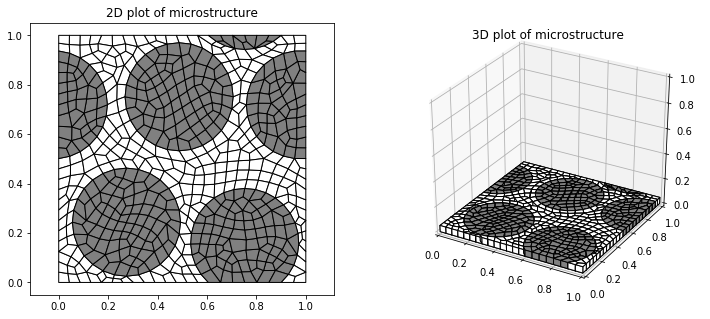

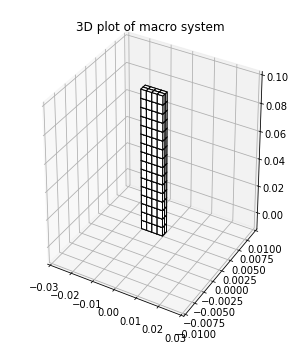

Computed slopes of the force-elongation tangent lines for fiber orientations 0, 30, 60 and 90 degrees
[1055553.9542117964, 323327.6049050231, 239870.19266638323, 323917.42292729346]


In [2]:
x0 = np.array([160.e9, 0.25, 5.e9, 0.45])
print('E_fiber = {} GPa, v_fiber = {}, E_matrix = {} GPa, v_matrix = {}'.format(x0[0]/1e9, x0[1], x0[2]/1e9, x0[3]))
x0 = x_real2norm(x0)
qoi = one_simulation(x0, plot_meshes_bool=True)
print('Computed slopes of the force-elongation tangent lines for fiber orientations 0, 30, 60 and 90 degrees')
print(qoi)

### Maximization as performed in original code presented in Sfepy

See http://sfepy.org/doc-devel/mat_optim.html. The function to be minimized is 
$$ \Phi = \sum_{\phi=0, 30, 60, 90} \left( 1-\frac{k_{computed, \phi}}{k_{experiment, \phi}} \right)^{2} $$
The identified parameters in this reference are: E_f=171 GPa, v_f=0.32, E_m=2.33 GPa, v_m = 0.20, but the authors note that the results may vary across SciPy versions and related libraries.

The parameters are defined over well-defined bounds, see x_L and x_U in material_homogenization.py. It is often best practice to scale the parameters so that they have comparable orders of magnitude, thus in the following the parameters are scaled so that they evolve in the $[0, 1]$ bounds. The functions x_real2norm and x_norm2real perform this scaling.

In [3]:
# Define the maximization function, as in http://sfepy.org/doc-devel/mat_optim.html.
def func(x0, exp_k):
    comp_k = one_simulation(x0)
    
    val = 0.0
    for e_k, c_k in zip(exp_k, comp_k):
        val += (1.0 - c_k / e_k)**2
    #val = np.sqrt(val)
    return val

In [4]:
from scipy.optimize import minimize
x0 = x_real2norm([160.e9, 0.25, 5.e9, 0.45])
xopt = minimize(func, x0, args=(data,), bounds=[(0, 1) for _ in range(4)], method = 'SLSQP')
print('number of function evaluations required for optimization: '.format(xopt.nit))
xfinal = x_norm2real(xopt.x)
print('Results of optimization procedure:')
print('E_fiber = {} GPa, v_fiber = {}, E_matrix = {} GPa, v_matrix = {}'.
      format(xfinal[0]/1e9, xfinal[1], xfinal[2]/1e9, xfinal[3]))

number of function evaluations required for optimization: 
Results of optimization procedure:
E_fiber = 161.76473951314404 GPa, v_fiber = 0.35951798296465887, E_matrix = 2.320917627200367 GPa, v_matrix = 0.2


### Maximum likelihood with UQpy

Recall that maximizing the likelihood of a model $y_{\phi}=f_{\phi}(\theta)+\varepsilon$, where $\varepsilon \sim N(\cdot; 0, \sigma_{\phi}^2)$ is equivalent to minimizing the weighted sum of squares $\frac{(y_{\phi}-f_{\phi}(\theta))^2}{2\sigma_{\phi}^2}$. Thus the above maximization can be performed using UQpy maximum likelihood estimator, setting $y_{\phi}=k_{experiment, \phi}, f_{\phi}(\theta)=k_{computed, \phi}, \sigma_{\phi}^2=\frac{1}{2} k_{experiment, \phi}^2$. This is done in the following by setting the error_covariance input accordingly.

In [5]:
# Create a model
model = Model(n_params=4, model_type='python', 
              model_script='material_homogenization.py', model_object_name = 'one_simulation',
              error_covariance=1/2*data**2, var_names = var_names)

# Maximum likelihood with weighted variance
ml_estimator = MLEstimation(model=model, data=data, bounds=[(0, 1) for _ in range(4)],
                            x0=x_real2norm([160.e9, 0.25, 5.e9, 0.45]))
xfinal = x_norm2real(ml_estimator.param)
print('Results of ML procedure:')
print('E_fiber = {} GPa, v_fiber = {}, E_matrix = {} GPa, v_matrix = {}'.
      format(xfinal[0]/1e9, xfinal[1], xfinal[2]/1e9, xfinal[3]))

Results of ML procedure:
E_fiber = 161.7914337201444 GPa, v_fiber = 0.3489572246915266, E_matrix = 2.3206528493209926 GPa, v_matrix = 0.2


When defining a model in UQPy, it is possible to plot the log-likelihood function as a function of the parameters. In the following cell we fix three parameters $\theta_{i1, i2, i3}$ out of the four unknown parameters and plot the conditional log-likelihood as we vary the fourth parameter over its range. In the following cell, we plot the variation of the log-likelihood as we vary two parameters.

Such analysis helps in understanding which parameters most affect the likelihood.

Conditional log likelihood, when three parameters are fixed to their max likelihood value.


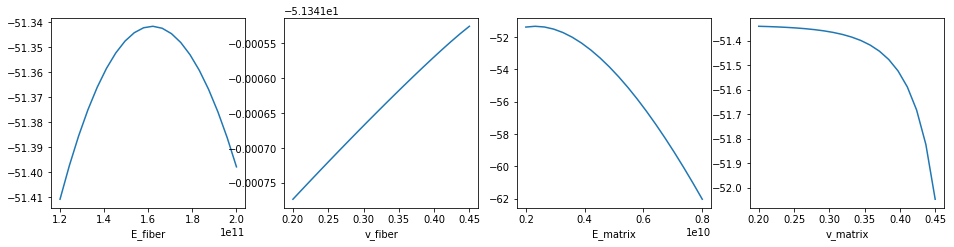

In [5]:
model = Model(n_params=4, model_type='python', 
              model_script='material_homogenization.py', model_object_name = 'one_simulation',
              error_covariance=1/2*data**2, var_names = ['E_f', 'v_f', 'E_m', 'v_m'])

# Look at the likelihood surfaces in 2D, fix the remaining two parameters
fixed_p = x_real2norm([161.79e9, 0.3490, 2.3207e9, 0.20])

print('Conditional log likelihood, when three parameters are fixed to their max likelihood value.')
npoints = 20
fig, ax = plt.subplots(ncols=4, figsize=(16,3.5))
for j in range(4):
    xx = np.linspace(0, 1, npoints)
    samples = fixed_p.reshape((1,4))*np.ones((npoints,4))
    samples[:,j] = xx
    tmp = np.array([x_norm2real(s) for s in samples])
    zz = model.log_like(data, samples)
    ax[j].plot(tmp[:,j], zz)
    ax[j].set_xlabel(var_names[j])
plt.show(fig)

Conditional log likelihood, when two parameters are fixed to their max likelihood value.


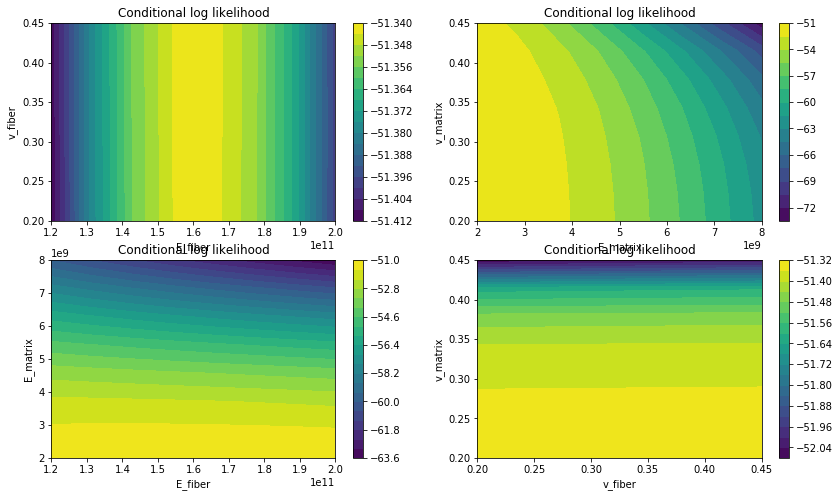

In [6]:
print('Conditional log likelihood, when two parameters are fixed to their max likelihood value.')
npoints = 8
vars_d2 = [[0, 1], [2, 3], [0, 2], [1, 3]]
axs = [[0,0], [0,1], [1,0], [1,1]]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,8))
for j, var_d2 in enumerate(vars_d2):
    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    xx, yy = np.meshgrid(x, y)
    xx, yy = xx.reshape((-1,)), yy.reshape((-1,))
    samples = fixed_p.reshape((1,4))*np.ones((npoints**2,4))
    samples[:,var_d2[0]] = xx
    samples[:,var_d2[1]] = yy
    zz = model.log_like(data, samples)
    tmp = np.array([x_norm2real(s) for s in samples])
    x, y = tmp[:,var_d2[0]], tmp[:,var_d2[1]]
    ax_j = ax[axs[j][0],axs[j][1]]
    t = ax_j.contourf(x.reshape((npoints,npoints)),y.reshape((npoints,npoints)),zz.reshape((npoints,npoints)), 20)
    ax_j.set_title('Conditional log likelihood')
    ax_j.set_xlabel(var_names[var_d2[0]])
    ax_j.set_ylabel(var_names[var_d2[1]])
    cbar = plt.colorbar(t, ax=ax_j)
plt.show(fig)

### Pdf estimation with UQpy

Run MCMC on the problem defined above. When performing a Bayesian analysis, it is important to carefully define both the prior of the parameters and the error_covariance of the model. Here the prior is chosen uniform over [0, 1], the error_covariance as $1/100*data**2$, meaning that the error in the measurements is proportional to the measured value, with a coefficient of variation of 10%.

In [7]:
# Create a model
model = Model(n_params=4, model_type='python', 
              model_script='material_homogenization.py', model_object_name = 'one_simulation',
              error_covariance=1/100*data**2, var_names = ['E_f', 'v_f', 'E_m', 'v_m'],
              ntasks=4, prior_name=['uniform']*4, prior_params=[[0,1]]*4)

Several small MCMC runs were performed to try and find the best scale parameters for this problem. Note that it may take about 30 minutes to run MCMC with 300 samples. The code to run to perform parameter estimation with MCMC is shown in the following cell. Results of several runs were saved in a file called 'mcmc_results_last.pkl'. The following scale parameters were tried:
- mcmc_0: [0.1, 0.1, 0.02, 0.05]
- mcmc_1: [0.15, 0.2, 0.02, 0.1]
- mcmc_2: [0.2, 0.25, 0.04, 0.1]
- mcmc_3: [0.2, 0.25, 0.2, 0.2]
- mcmc_4: [0.2, 0.25, 0.04, 0.1], 5000 samples
- mcmc_4: [0.2, 0.25, 0.04, 0.1], 10000 samples <br>
In the following we show the effect of modifying the scale parameter on MCMC results.

In [9]:
## This would be the code to run to perform parameter estimation using MCMC
#be = BayesParameterEstimation(data=data, model=model, sampling_method = 'MCMC', nsamples=300,
#                              algorithm = 'MH', jump=1, nburn=0, pdf_proposal_type = 'Normal',
#                              pdf_proposal_scale = [0.1, 0.1, 0.02, 0.05], 
#                              seed = x_real2norm([162e9, 0.35, 2.32e9, 0.25]))
## Save the data into a pickle file
#import pickle
#with open('mcmc_results_test.pkl', 'wb') as f:
#    pickle.dump({'mcmc_0': be}, f)


scale parameter is too large, acceptance ratio too small:
acceptance ratio: 0.05016722408026756
last_sample: [0.39964438 0.21510233 0.05128564 0.29492239]
sample std: [0.15248433 0.30084983 0.01917713 0.12184438]


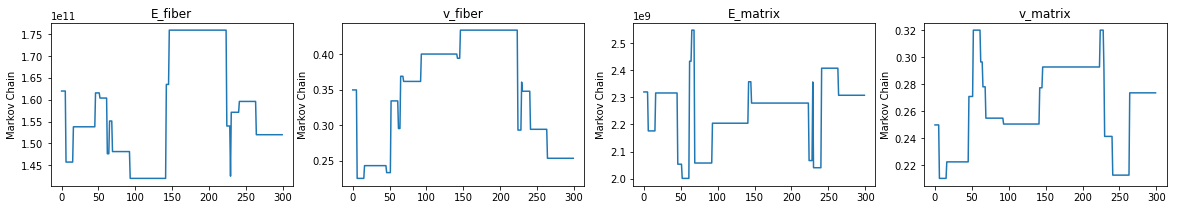


scale_parameter is too small:
acceptance ratio: 0.5986622073578596
last_sample: [0.8223653  0.19562838 0.05823897 0.28713966]
sample std: [0.19418693 0.32902352 0.02017681 0.12043262]


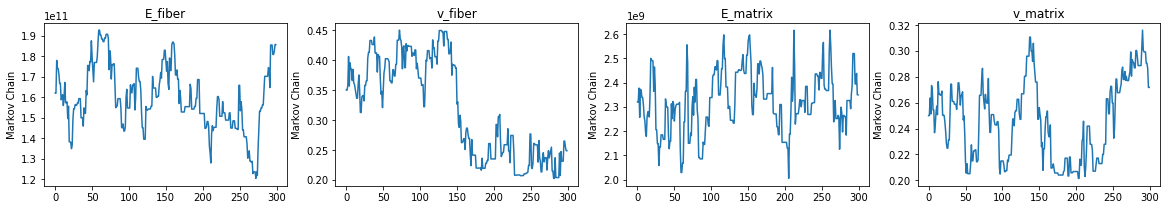


good scale - 300 samples:
acceptance ratio: 0.3076923076923077
last_sample: [0.5280907  0.08829753 0.05908275 0.44748551]
sample std: [0.18747909 0.30004715 0.02319272 0.10789175]


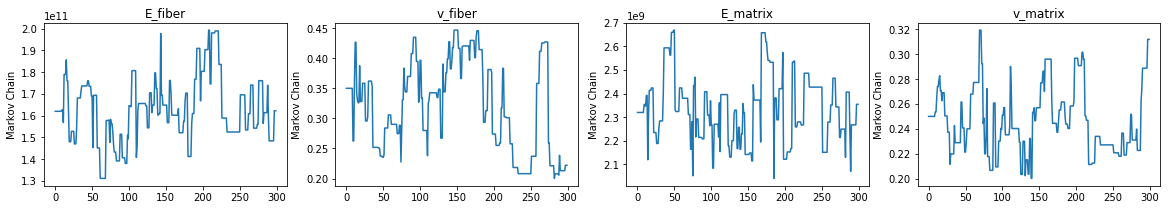


good scale - 5000 samples:
acceptance ratio: 0.29445889177835566
last_sample: [0.7212818  0.55499597 0.06195577 0.0704469 ]
sample std: [0.18993732 0.28795153 0.02414522 0.15987673]


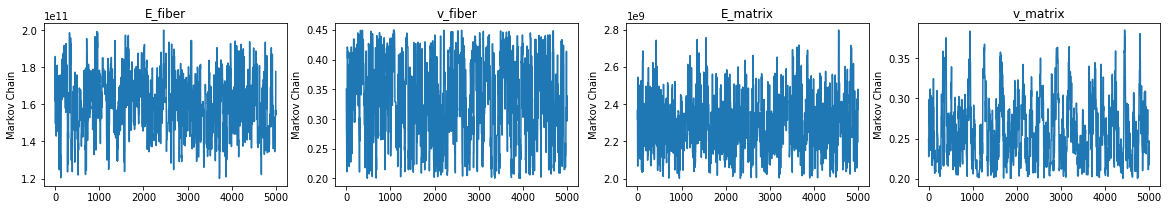

In [10]:
import pickle
with open('mcmc_results_last.pkl', 'rb') as f:
    mcmc_results = pickle.load(f)
l = ['mcmc_3', 'mcmc_0', 'mcmc_2', 'mcmc_4']
to_print = ['scale parameter is too large, acceptance ratio too small:', 'scale_parameter is too small:', 
            'good scale - 300 samples:', 'good scale - 5000 samples:']
for j, l_j in enumerate(l):
    be = mcmc_results[l_j]
    print('\n'+to_print[j])
    print('acceptance ratio: {}'.format(be.accept_ratio))
    print('last_sample: {}'.format(be.samples[-1,:]))
    print('sample std: {}'.format(np.std(be.samples, axis=0)))
    fig, ax = plt.subplots(ncols=4, figsize=(20,3))
    tmp = np.array([x_norm2real(s) for s in be.samples])
    for i, param_name in enumerate(var_names):
        ax[i].plot(tmp[:,i])
        ax[i].set_title(param_name)
        ax[i].set_ylabel('Markov Chain')
    plt.show(fig)

Then we use the previous 5000 samples to plot the posterior pdfs. We take out a few samples at the beginning, since the seed was given as the maximum likelihood estimate we can assume that the burn-in period would be small in this example. We also keep only 1 out of 5 samples to avoid for them to be correlated.

(2450, 4)


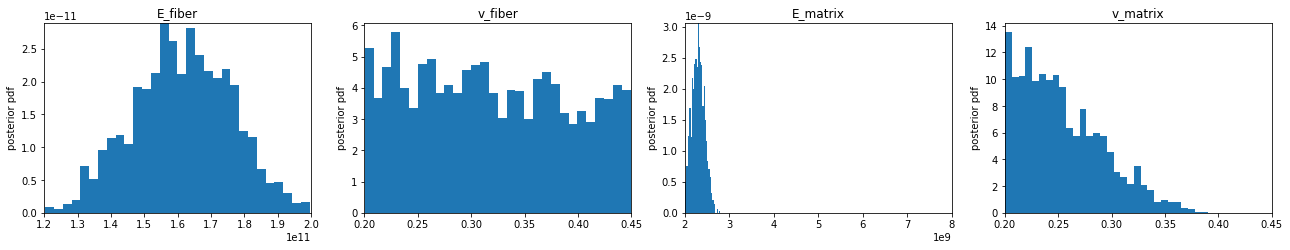

In [11]:
nburn = 200
jump = 4

be = mcmc_results['mcmc_5']
samples = be.samples[nburn::jump]
print(samples.shape)
samples = np.array([x_norm2real(x) for x in samples])
x_L = x_norm2real([0, 0, 0, 0])
x_U = x_norm2real([1, 1, 1, 1])

fig, ax = plt.subplots(ncols=4, figsize=(22,3.5))
for i, param_name in enumerate(var_names):
    ax[i].hist(samples[:,i], density=True, bins=30)
    ax[i].set_title(param_name)
    ax[i].set_ylabel('posterior pdf')
    ax[i].set_xlim([x_L[i], x_U[i]])

Diagnostics for MCMC 

Univariate Effective Sample Size in each dimension:
Parameter # 1: ESS = 30597.110150286753, minimum ESS recommended = 6146.334113110603
Parameter # 2: ESS = 22160.584954255188, minimum ESS recommended = 6146.334113110603
Parameter # 3: ESS = 32741.359674994954, minimum ESS recommended = 6146.334113110603
Parameter # 4: ESS = 11958.155457352726, minimum ESS recommended = 6146.334113110603

Multivariate Effective Sample Size:
Multivariate ESS = 26166.862214878456, minimum ESS recommended = 8430.573891876938


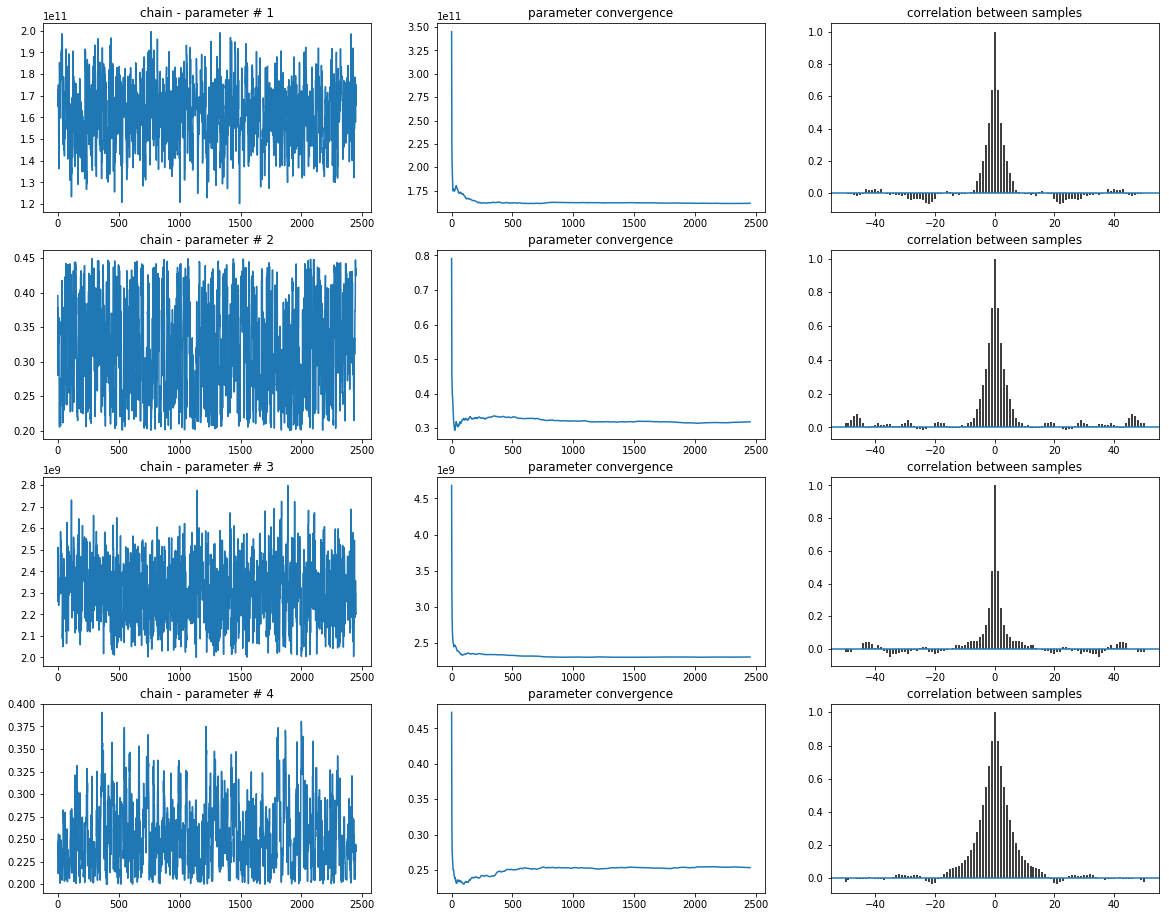

(<Figure size 1440x1152 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0fdf53c8>,
       dtype=object))

In [12]:
from UQpy.Utilities import diagnostics
diagnostics(sampling_method='MCMC', samples=samples)